# MERS

# Imports Section 

In [5]:
import altair as alt
import Bio.Phylo
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [43]:
try: 
    snakemake.input.tree 
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


# Trying out MERS

In [6]:
tree = Bio.Phylo.read("../mers-nextstrain/results/tree.nwk", "newick")

In [7]:
tree_records = []
heights = get_y_positions(tree)
for node in tree.find_clades(terminal=True):
    tree_records.append(dict(accession=node.name, y=heights[node]))

In [8]:
tree_df = pd.DataFrame(tree_records)

In [9]:
tree_df

,accession,y
0,JX869059,1
1,KC776174,2
2,KX108943,3
3,KU740200,4
4,KJ477102,5
...,...,...
269,KX034099,270
270,KX034100,271
271,KT374052,272
272,KU308549,273


In [11]:
tree_df["accession"].value_counts().sort_values(ascending=False)

KU233362    1
KT368835    1
KT868865    1
KT868867    1
KM027261    1
           ..
KT806052    1
KJ156888    1
KT374051    1
KT806055    1
KJ156934    1
Name: accession, Length: 243, dtype: int64

In [12]:
host_information = pd.read_csv("../mers-nextstrain/results/metadata.tsv", sep='\t')

In [13]:
host_information

,strain,accession,host,date
0,Jeddah-1,KF958702,human,2013-11-05
1,Riyadh_3_2013,KF600613,human,2013-02-05
2,Riyadh_4_2013,KJ156952,human,2013-03-01
3,Riyadh_5_2013,KJ156944,human,2013-07-02
4,Taif_1_2013,KJ156949,human,2013-06-12
...,...,...,...,...
268,Al-Hasa_28_2013,KJ156887,human,2013-06-22
269,Asir_2_2013,KJ156863,human,2013-08-05
270,Hafr-Al-Batin_4_2013,KJ156931,human,2013-08-25
271,Hafr-Al-Batin_5_2013,KJ156951,human,2013-08-25


In [16]:
node_data = tree_df.merge(host_information, on="accession")

,accession,y,strain,host,date
0,JX869059,1,EMC/2012,human,2012-06-13
1,KC776174,2,Jordan-N3/2012,human,2012-04-15
2,KX108943,3,D998/15,camel,2015-04-23
3,KU740200,4,Egypt_NRCE-NC163/2014,camel,2014-12-17
4,KJ477102,5,NRCE-HKU205,camel,2013-11-15
...,...,...,...,...,...
1198,KX034099,270,KOR/Seoul/169-2015,human,2015-06-26
1199,KX034100,271,KOR/Seoul/177-3-2015,human,2015-07-03
1200,KT374052,272,KOREA/Seoul/014-1-2015,human,2015-05-31
1201,KU308549,273,Korea/Seoul/SNU1-035/2015,human,2015-06-08


In [40]:
node_data["date"] = pd.to_datetime(node_data["date"])

In [41]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

In [43]:
fraction_date = [year_fraction(date) for date in node_data["date"]]

In [45]:
node_data["date"] = fraction_date

In [47]:
node_data

,accession,y,strain,host,date
0,JX869059,1,EMC/2012,human,2012.448087
1,KC776174,2,Jordan-N3/2012,human,2012.286885
2,KX108943,3,D998/15,camel,2015.306849
3,KU740200,4,Egypt_NRCE-NC163/2014,camel,2014.958904
4,KJ477102,5,NRCE-HKU205,camel,2013.871233
...,...,...,...,...,...
1198,KX034099,270,KOR/Seoul/169-2015,human,2015.482192
1199,KX034100,271,KOR/Seoul/177-3-2015,human,2015.501370
1200,KT374052,272,KOREA/Seoul/014-1-2015,human,2015.410959
1201,KU308549,273,Korea/Seoul/SNU1-035/2015,human,2015.432877


In [19]:
node_data["strain"].value_counts().sort_values(ascending=False)

Riyadh_KKUH_1066           31
Riyadh_KKUH_0944           31
Riyadh-KKUH-105            31
Riyadh-KKUH-291            31
Camel_Egypt_NRCE-HKU271    31
                           ..
Riyadh/Ry64/2015            1
KOR/Seoul/080-3-2015        1
Al-Hasa_14_2013             1
Riyadh_17_2013              1
Al-Hasa_17_2013             1
Name: strain, Length: 273, dtype: int64

In [48]:
similarity_matrix = pd.read_csv("../mers-nextstrain/results/distance_matrix.csv", index_col=0)

In [49]:
indices_to_drop = similarity_matrix[~similarity_matrix.index.isin(host_information["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix[similarity_matrix.index.isin(host_information["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix.drop(indices_to_drop.index, axis=1)
similarity_matrix

,0,1,2,3,4,5,6,7,8,9,...,263,264,265,266,267,268,269,270,271,272
Jeddah-1,0,35,31,20,14,11,25,87,83,83,...,84,93,93,111,46,54,47,45,51,52
Riyadh_3_2013,35,0,34,31,33,24,34,87,84,84,...,86,95,95,107,45,55,49,43,51,51
Riyadh_4_2013,31,34,0,29,29,17,30,69,66,66,...,76,77,85,102,34,40,36,30,36,35
Riyadh_5_2013,20,31,29,0,22,15,25,84,81,81,...,81,90,90,105,43,54,47,43,48,51
Taif_1_2013,14,33,29,22,0,4,23,84,81,81,...,83,92,92,109,45,52,46,44,50,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Al-Hasa_28_2013,54,55,40,54,52,25,51,38,36,36,...,56,49,60,83,17,0,31,25,30,32
Asir_2_2013,47,49,36,47,46,29,44,28,25,25,...,58,54,63,69,20,31,0,19,29,33
Hafr-Al-Batin_4_2013,45,43,30,43,44,24,41,27,25,25,...,42,31,44,64,17,25,19,0,7,13
Hafr-Al-Batin_5_2013,51,51,36,48,50,25,49,35,35,35,...,43,29,46,76,28,30,29,7,0,17


In [50]:
node_df = host_information[host_information["strain"].isin(similarity_matrix.index)].dropna(how = 'all')

In [51]:
principalDf = pd.read_csv("../mers-nextstrain/results/embed_pca.csv", index_col=0)
explained_variance_df = pd.read_csv("../mers-nextstrain/results/explained_variance_pca.csv")

In [52]:
merged_pca_df = principalDf.merge(node_data, on="strain")

In [53]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

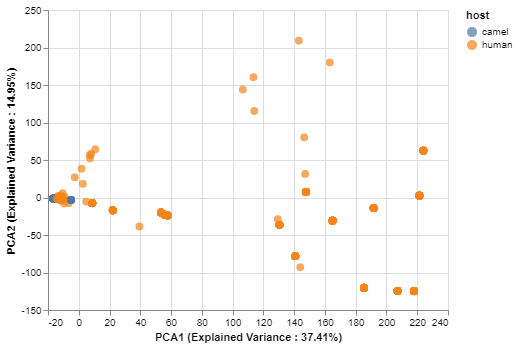

In [54]:
PCAFluBrush = scatterplot_with_tooltip_interactive(merged_pca_df,'pca1','pca2','PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",['strain'],'host:N')
PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

In [74]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "host:N",['strain', "host"])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
PCAFluBrush.save("../docs/PCAMERSBrush.html")

In [61]:
MDS_df = pd.read_csv("../mers-nextstrain/results/embed_mds.csv",index_col=0)
merged_mds_df = MDS_df.merge(node_data, on="strain")

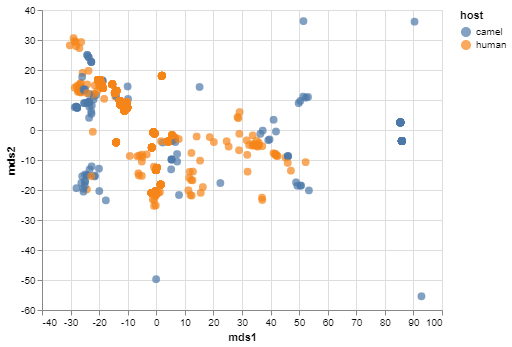

In [62]:
scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain'],'host:N')

In [73]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'host:N', ['strain'])
chart = list_of_chart[0]|list_of_chart[1]
chart.save("../docs/MDSMERSBrush.html")

In [64]:
TSNE_df = pd.read_csv("../mers-nextstrain/results/embed_t-sne.csv",index_col=0)
merged_tsne_df = TSNE_df.merge(node_data, on="strain")

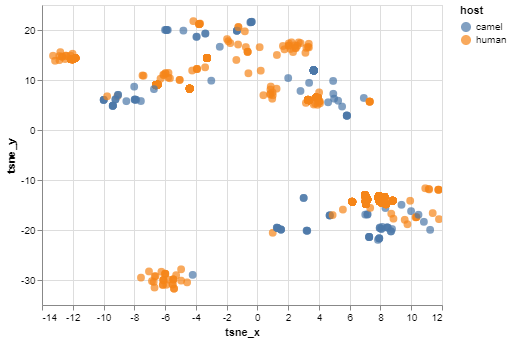

In [65]:
scatterplot_with_tooltip_interactive(merged_tsne_df,'tsne_x','tsne_y','tsne_x','tsne_y',['strain'],'host:N')

In [72]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'host:N',
    ["host:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
chart.save("../docs/TSNEMERSBrush.html")

In [67]:
UMAP_df = pd.read_csv("../mers-nextstrain/results/embed_umap.csv",index_col=0)
merged_umap_df = UMAP_df.merge(node_data, on="strain")

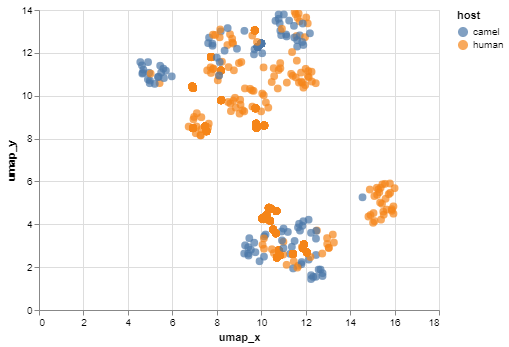

In [68]:
scatterplot_with_tooltip_interactive(merged_umap_df,'umap_x','umap_y','umap_x','umap_y',['strain'],'host:N')

In [71]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'host',
    ["host","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
chart.save("../docs/UMAPMERSBrush.html")